In [2]:
# student name:Yao Xiao, student number: 2019180015
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np    
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import auc, precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
SEED=42

Text(0.5, 1.0, 'Diabetes Statistic')

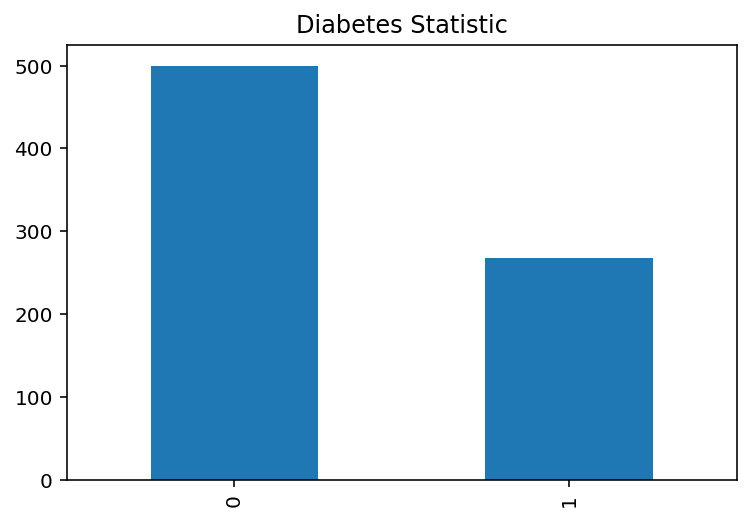

In [3]:
dataset = pd.read_csv('diabetes.csv')
dataset['Outcome'].value_counts().plot(kind='bar').set_title('Diabetes Statistic')

0
1
2
3
4
5
6
7


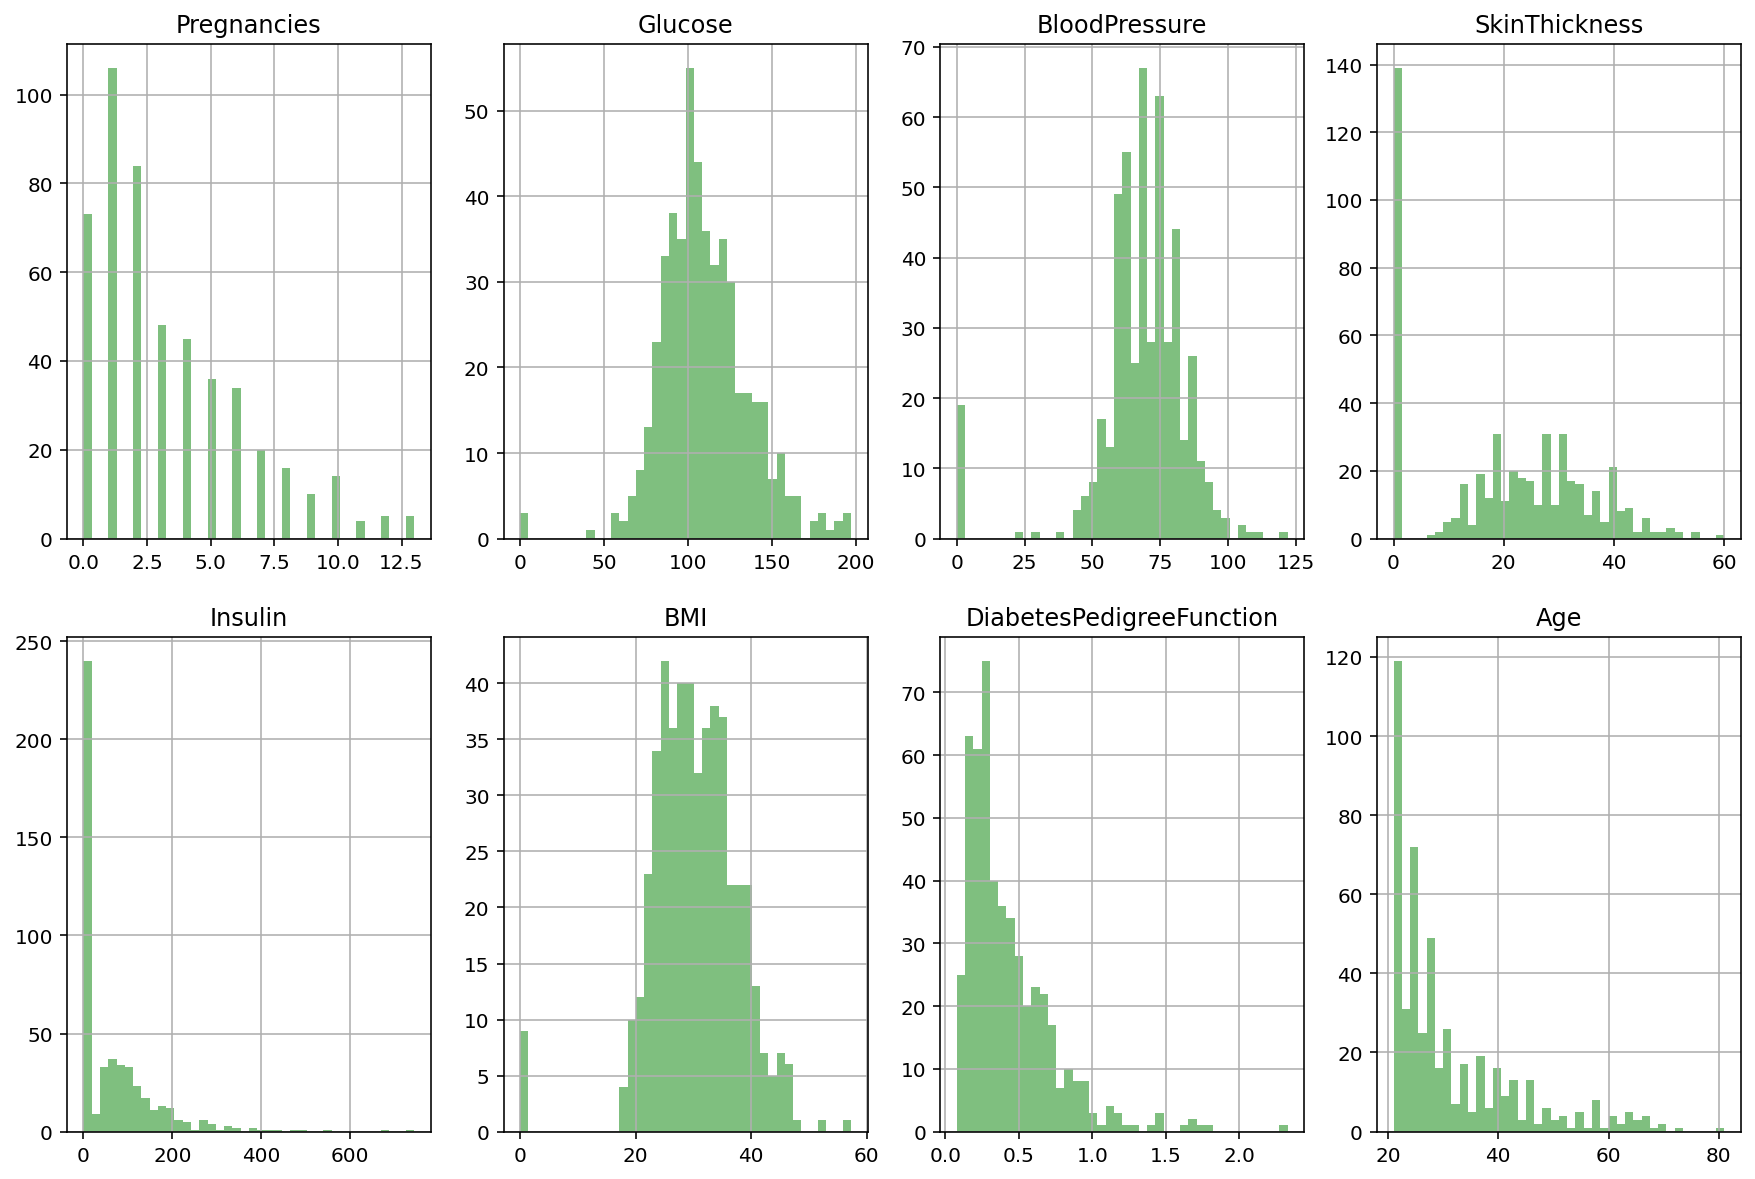

In [4]:
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

rows, cols = 2, 4
fig, ax = plt.subplots(rows, cols, figsize=(15,10) )
subr, subc = 0, 0 

for i, feature in enumerate(features):
    if subc == cols - 1:
        subr += 1
    subc = i % cols
    print(i)
    
    dataset[dataset.Outcome==0][feature].hist(bins=40, color='green', alpha=0.5 ,ax=ax[subr, subc]).set_title(feature)

In [516]:
# It can see that there are some zero datas will influence the accuracy, so choosing the medium to replace theme 

In [517]:
dataset.Glucose.replace(0, np.nan, inplace=True)
dataset.Glucose.replace(np.nan, dataset['Glucose'].median(), inplace=True)
dataset.BloodPressure.replace(0, np.nan, inplace=True)
dataset.BloodPressure.replace(np.nan, dataset['BloodPressure'].median(), inplace=True)
dataset.SkinThickness.replace(0, np.nan, inplace=True)
dataset.SkinThickness.replace(np.nan, dataset['SkinThickness'].median(), inplace=True)
dataset.Insulin.replace(0, np.nan, inplace=True)
dataset.Insulin.replace(np.nan, inplace=True)
dataset.BMI.replace(0, np.nan, inplace=True)
dataset.BMI.replace(np.nan, dataset['BMI'].median(), inplace=True)

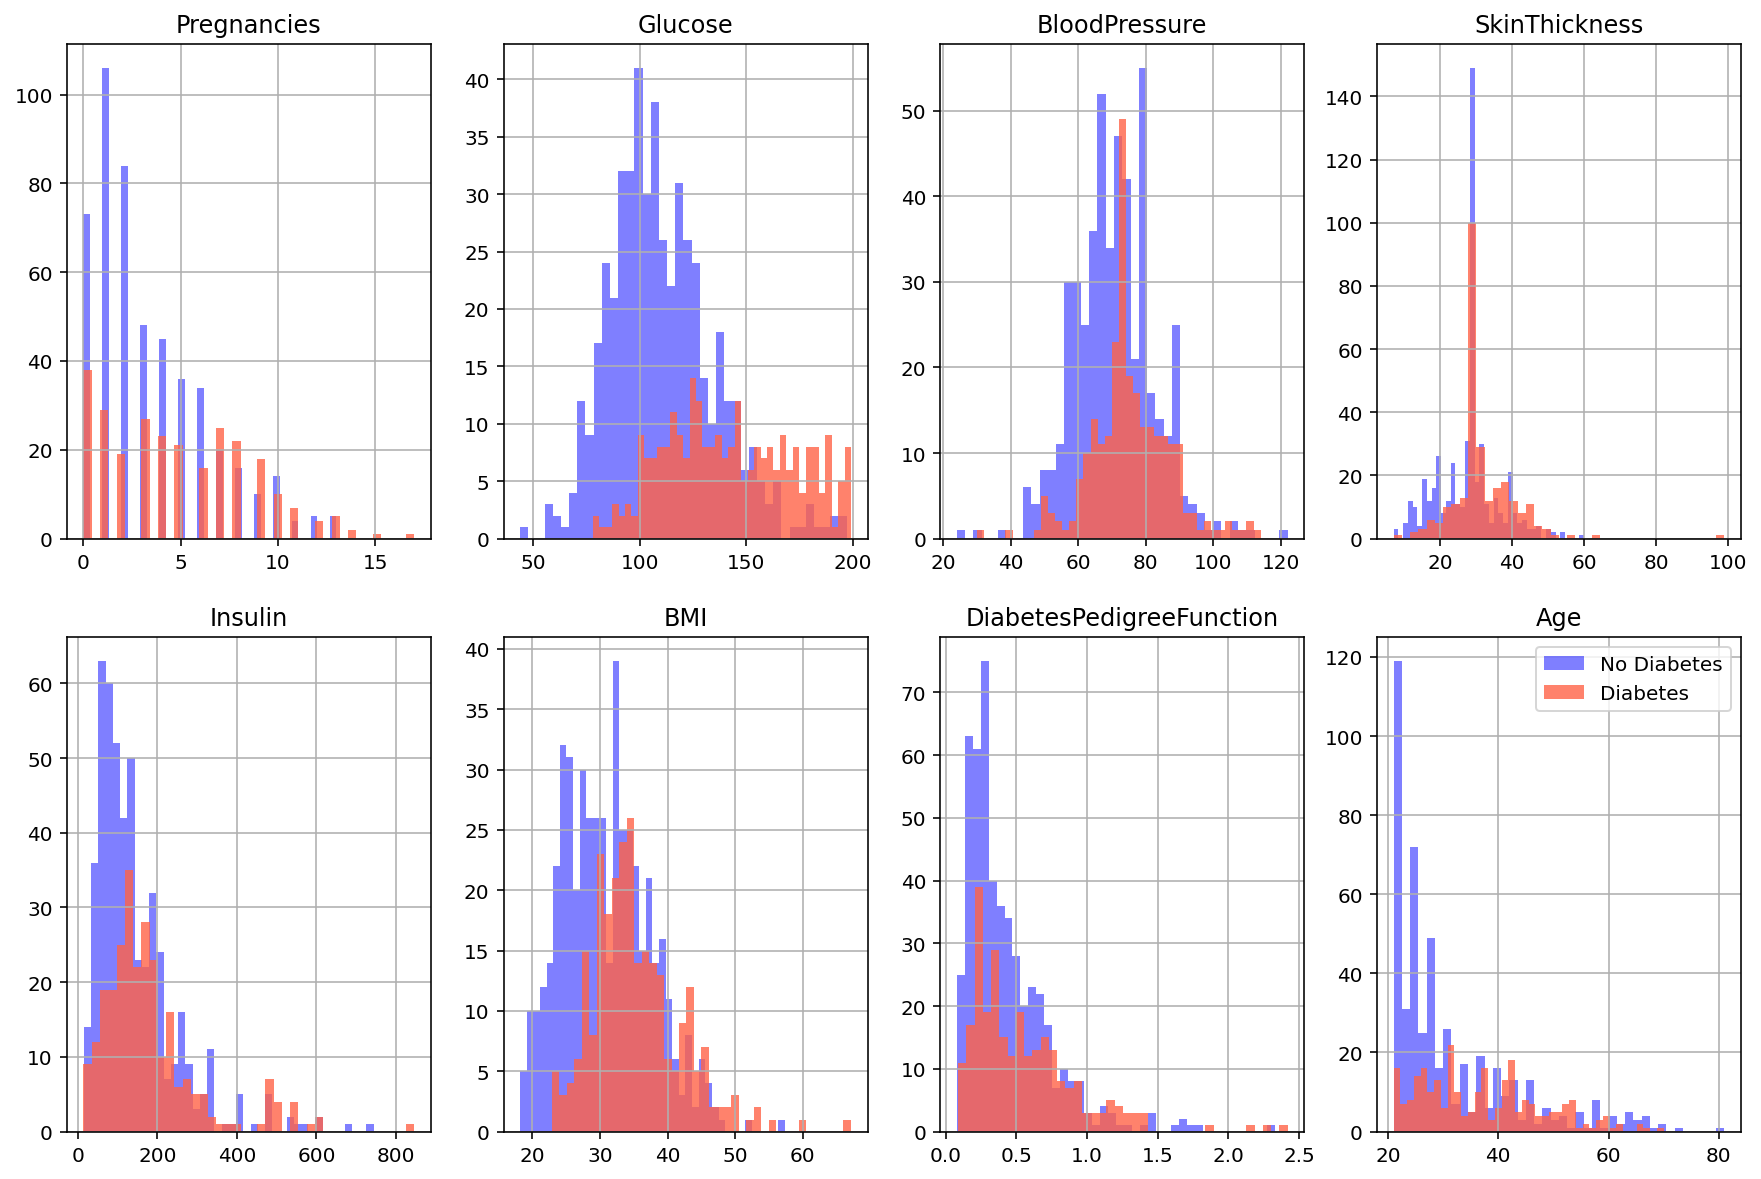

In [518]:
rows, colss = 2, 4
fig, ax = plt.subplots(rows, cols, figsize=(15,10) )
subr, subc = 0, 0 

for i, feature in enumerate(features):
    if subc == cols - 1:
        subr += 1
    subc = i % cols
    
    
    dataset[dataset.Outcome==0][feature].hist(bins=40, color='blue', alpha=0.5 ,ax=ax[subr, subc]).set_title(feature)
    dataset[dataset.Outcome==1][feature].hist(bins=40, color='tomato', alpha=0.8 ,ax=ax[subr, subc])

plt.legend(['No Diabetes', 'Diabetes'])
fig.subplots_adjust(hspace=0.2)

In [469]:
# fit
# delete Outcome column
x = dataset.drop('Outcome', axis=1)
y = dataset['Outcome']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=SEED, stratify=y)
print('x_train: ', x_train.shape)
print('y_train: ', y_train.shape)
print('x_test: ', x_test.shape)
print('y_test: ', y_test.shape)

x_train:  (614, 8)
y_train:  (614,)
x_test:  (154, 8)
y_test:  (154,)


In [470]:
# for imbalance dataset, ensure the output same proportion
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

def baseline_record(model, x_train, x_test, y_train, y_test, name):
    model.fit(x_train, y_train)
    acc = np.mean(cross_val_score(model, x_train, y_train, cv=skf, scoring='accuracy'))
    recall = np.mean(cross_val_score(model, x_train, y_train, cv=skf, scoring='recall'))
    f1 = np.mean(cross_val_score(model, x_train, y_train, cv=skf, scoring='f1'))
    
    y_pred = y_pred = model.predict(x_test)
    logloss = log_loss(y_test, y_pred)
    
    dataset_model = pd.DataFrame({'model': [name], 'acc': [acc], 'recall': [recall], 'f1': [f1],'logloss': [logloss], 'timetaken': [0]})
    
    return dataset_model

gnb = GaussianNB()
knn = KNeighborsClassifier()
rfc = RandomForestClassifier()

    
x_train = x_train.fillna(x_train.mean())
dataset_models = pd.concat([baseline_record(gnb, x_train, x_test, y_train, y_test, 'GaussianNB'),
                            baseline_record(knn, x_train, x_test, y_train, y_test, 'KNN'),
                            baseline_record(rfc, x_train, x_test, y_train, y_test, 'RandomForest')], axis=0).reset_index()
                           
    
dataset_models = dataset_models.drop('index', axis=1)
dataset_models

,model,acc,recall,f1,logloss,timetaken
0,GaussianNB,0.754112,0.607641,0.632677,10.092624,0
1,KNN,0.737758,0.565670,0.600649,10.092603,0
2,RandomForest,0.771985,0.561019,0.618268,9.644027,0


In [471]:
def optimise_record(model, x_train, x_test, y_train, y_test, model_name):
    model.fit(x_train, y_train)
    optimal_th = 0.5
    
    for i in range(0,3):
        score_list = []
        th_list = [np.linspace(optimal_th-0.4999, optimal_th+0.4999, 11), 
                   np.linspace(optimal_th-0.1, optimal_th+0.1, 21), 
                   np.linspace(optimal_th-0.01, optimal_th+0.01, 21)]
        
        for th in th_list[i]:
            if th<0: 
                score_list.append(-1)
                continue
            y_pred = (model.predict_proba(x_test)[:,1] >= th)
            f1scor = f1_score(y_test, y_pred)
            score_list.append(f1scor)
        optimal_th = float(th_list[i][score_list.index(max(score_list))])

    print('optimal F1 score = {:.4f}'.format(max(score_list)))
    print('optimal threshold = {:.3f}'.format(optimal_th))

    print(model_name, 'acc score is')
    print('Training: {:.2f}%'.format(100*model.score(x_train, y_train)))
    accuracy      = np.mean(cross_val_score(model, x_train, y_train, cv=skf, scoring='accuracy'))
    print('Test set: {:.2f}%'.format(100*accuracy))

    y_pred = (model.predict_proba(x_test)[:,1] >= 0.25)
    print('\nAdjust to 0.25:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))
    
    y_pred = model.predict(x_test)
    print('\nDefault 0.50:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))
    
    y_pred = (model.predict_proba(x_test)[:,1] >= 0.75)
    print('\nAdjust to 0.75:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))
    
    y_pred = (model.predict_proba(x_test)[:,1] >= optimal_th)
    print('\nOptimal threshold {:.3f}'.format(optimal_th))
    precision    = precision_score(y_test, y_pred)
    recall       = recall_score(y_test, y_pred)
    f1score      = f1_score(y_test, y_pred)
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(precision, recall, f1score))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))
    
    y_pred = model.predict_proba(x_test)[:,1] 
    logloss      = log_loss(y_test, y_pred)
    print(model_name, 'Log-loss: {:.4f}'.format(logloss))

    dataset_model = pd.DataFrame({'model': [model_name], 'acc': [accuracy], 'recall': [recall], 'f1': [f1score], 'logloss': [logloss], 'timetaken': [1000]}) 
    return dataset_model

In [472]:
print('\n=====GaussianNB=====')
time1 = time.time()
gnb = GaussianNB()
model1 = optimise_record(gnb, x_train, x_test, y_train, y_test, 'GaussianNB')
model1.timetaken[0] = time.time() - time1


=====GaussianNB=====
optimal F1 score = 0.6577
optimal threshold = 0.088
GaussianNB acc score is
Training: 76.06%
Test set: 75.41%

Adjust to 0.25:
Precision: 0.5417,   Recall: 0.7222,   F1 Score: 0.6190
GaussianNB confusion matrix: 
 [[67 33]
 [15 39]]

Default 0.50:
Precision: 0.5789,   Recall: 0.6111,   F1 Score: 0.5946
GaussianNB confusion matrix: 
 [[76 24]
 [21 33]]

Adjust to 0.75:
Precision: 0.6444,   Recall: 0.5370,   F1 Score: 0.5859
GaussianNB confusion matrix: 
 [[84 16]
 [25 29]]

Optimal threshold 0.088
Precision: 0.5158,   Recall: 0.9074,   F1 Score: 0.6577
GaussianNB confusion matrix: 
 [[54 46]
 [ 5 49]]
GaussianNB Log-loss: 0.7596


In [473]:
print('\n=====KNN======')
time2 = time.time()
kf = KFold(n_splits=5, random_state=SEED, shuffle=True)
k_scores = []
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors = k)
    cvs = cross_val_score(knn, x_train, y_train, cv=kf, scoring='f1').mean()
    k_scores.append(cvs)
optimal_k = k_scores.index(max(k_scores))+1
print('optimal value of K =', optimal_k)

knn = KNeighborsClassifier(n_neighbors = optimal_k)
model2 = optimise_record(knn, x_train, x_test, y_train, y_test, 'KNN')
model2.timetaken[0] = time.time() - time2

knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)


=====KNN======
optimal value of K = 9
optimal F1 score = 0.6203
optimal threshold = 0.112
KNN acc score is
Training: 78.99%
Test set: 76.39%

Adjust to 0.25:
Precision: 0.5132,   Recall: 0.7222,   F1 Score: 0.6000
KNN confusion matrix: 
 [[63 37]
 [15 39]]

Default 0.50:
Precision: 0.5333,   Recall: 0.4444,   F1 Score: 0.4848
KNN confusion matrix: 
 [[79 21]
 [30 24]]

Adjust to 0.75:
Precision: 0.7222,   Recall: 0.2407,   F1 Score: 0.3611
KNN confusion matrix: 
 [[95  5]
 [41 13]]

Optimal threshold 0.112
Precision: 0.4712,   Recall: 0.9074,   F1 Score: 0.6203
KNN confusion matrix: 
 [[45 55]
 [ 5 49]]
KNN Log-loss: 0.7711


In [474]:
print('\n======RandomForestClassifier======')
time3 = time.time()
kf = KFold(n_splits=5, random_state=SEED, shuffle=True)  #produce the k folds
score_list = []
n_list = []
for n in [100, 150, 200, 250, 300, 350, 400, 450, 500]:
    randomforest = RandomForestClassifier(n_estimators=n)
    cvs = (cross_val_score(randomforest, x_train, y_train, cv=kf, scoring='f1')).mean()
    score_list.append(cvs)
    n_list.append(n)
print('optimal F1 score = {:.4f}'.format(max(score_list)))
optimal_n = int(n_list[score_list.index(max(score_list))])
print('optimal n_estimators = {:.0f}'.format(optimal_n))

rfc = RandomForestClassifier(n_estimators=optimal_n)
model3 = optimise_record(rfc, x_train, x_test, y_train, y_test, 'RandomForest')
model3.timetaken[0] = time.time() - time3


======RandomForestClassifier======
optimal F1 score = 0.6224
optimal n_estimators = 450
optimal F1 score = 0.6809
optimal threshold = 0.216
RandomForest acc score is
Training: 100.00%
Test set: 77.20%

Adjust to 0.25:
Precision: 0.5412,   Recall: 0.8519,   F1 Score: 0.6619
RandomForest confusion matrix: 
 [[61 39]
 [ 8 46]]

Default 0.50:
Precision: 0.6304,   Recall: 0.5370,   F1 Score: 0.5800
RandomForest confusion matrix: 
 [[83 17]
 [25 29]]

Adjust to 0.75:
Precision: 0.8000,   Recall: 0.1481,   F1 Score: 0.2500
RandomForest confusion matrix: 
 [[98  2]
 [46  8]]

Optimal threshold 0.216
Precision: 0.5517,   Recall: 0.8889,   F1 Score: 0.6809
RandomForest confusion matrix: 
 [[61 39]
 [ 6 48]]
RandomForest Log-loss: 0.4972


In [476]:
optimise_models= pd.concat([model1, model2, model3],axis = 0).reset_index()
optimise_models.drop('index', axis=1, inplace=True)
optimise_models

,model,acc,recall,f1,logloss,timetaken
0,GaussianNB,0.754112,0.907407,0.657718,0.759611,0
1,KNN,0.763854,0.907407,0.620253,0.771097,1
2,RandomForest,0.771998,0.888889,0.680851,0.497248,39


In [477]:
dataset_models

,model,acc,recall,f1,logloss,timetaken
0,GaussianNB,0.754112,0.607641,0.632677,10.092624,0
1,KNN,0.737758,0.565670,0.600649,10.092603,0
2,RandomForest,0.771985,0.561019,0.618268,9.644027,0


Text(0.5, 1.0, 'Log-Loss-Score')

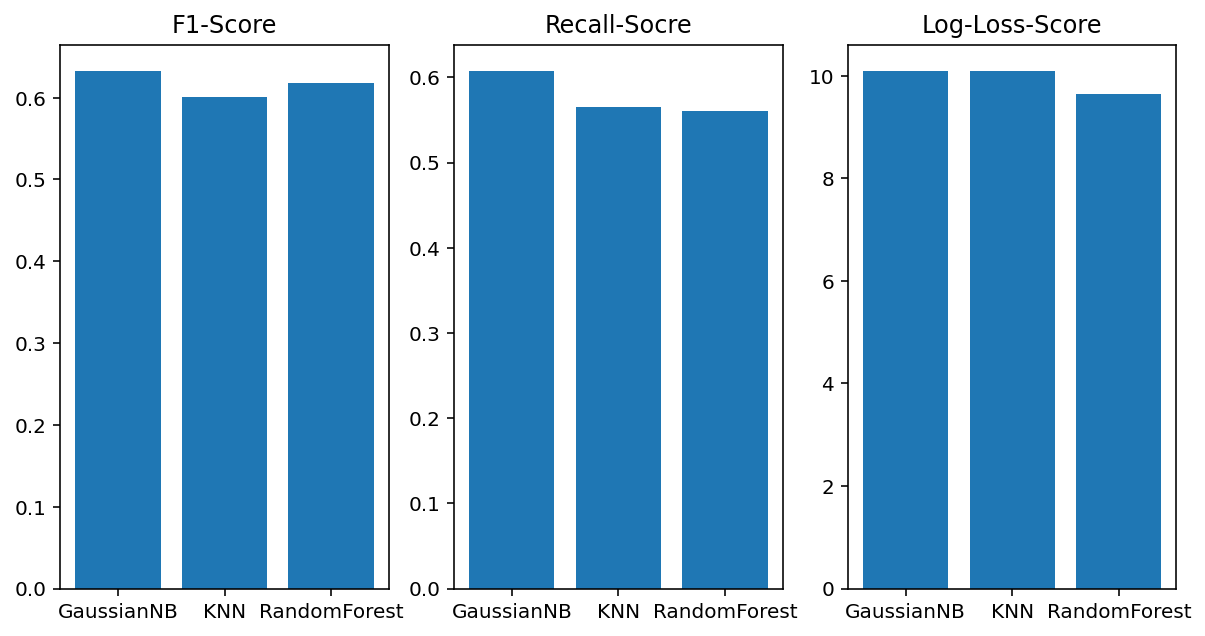

In [496]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))


ax[0].bar(dataset_models.model, dataset_models.f1)
ax[0].set_title('F1-Score')

ax[1].bar(dataset_models.model, dataset_models.recall)
ax[1].set_title('Recall-Socre')

ax[2].bar(dataset_models.model, dataset_models.logloss)
ax[2].set_title('Log-Loss-Score')

Text(0.5, 1.0, 'Time taken')

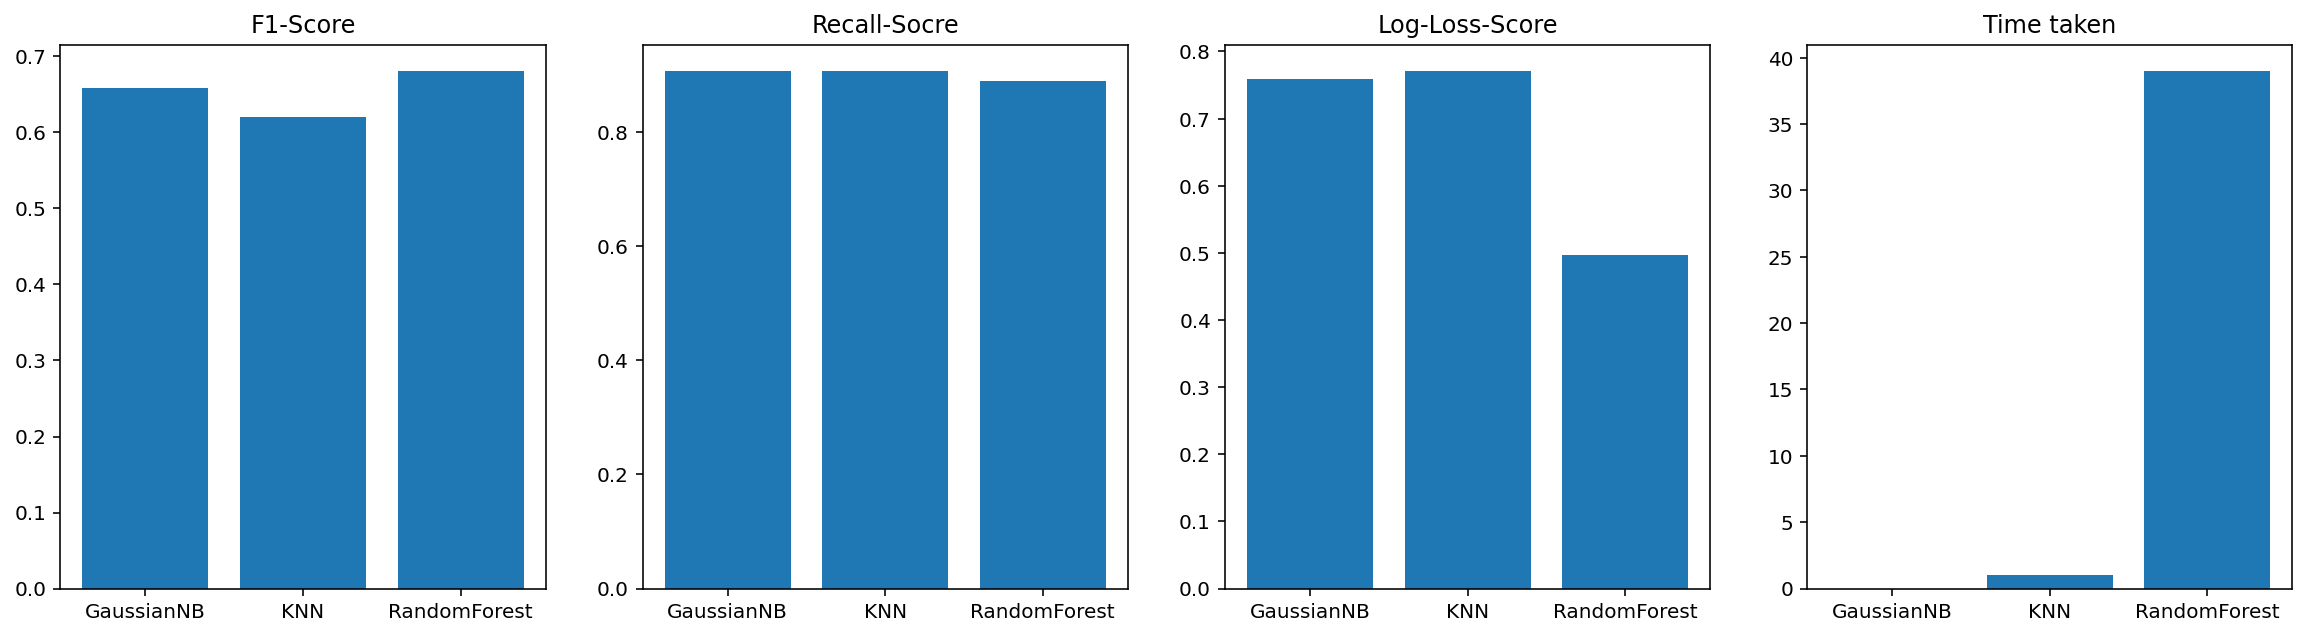

In [503]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))


ax[0].bar(optimise_models.model, optimise_models.f1)
ax[0].set_title('F1-Score')

ax[1].bar(optimise_models.model, optimise_models.recall)
ax[1].set_title('Recall-Socre')

ax[2].bar(optimise_models.model, optimise_models.logloss)
ax[2].set_title('Log-Loss-Score')

ax[3].bar(optimise_models.model, optimise_models.timetaken)
ax[3].set_title('Time taken')

Text(0.5, 1.0, 'Top Features Of Diabetes')

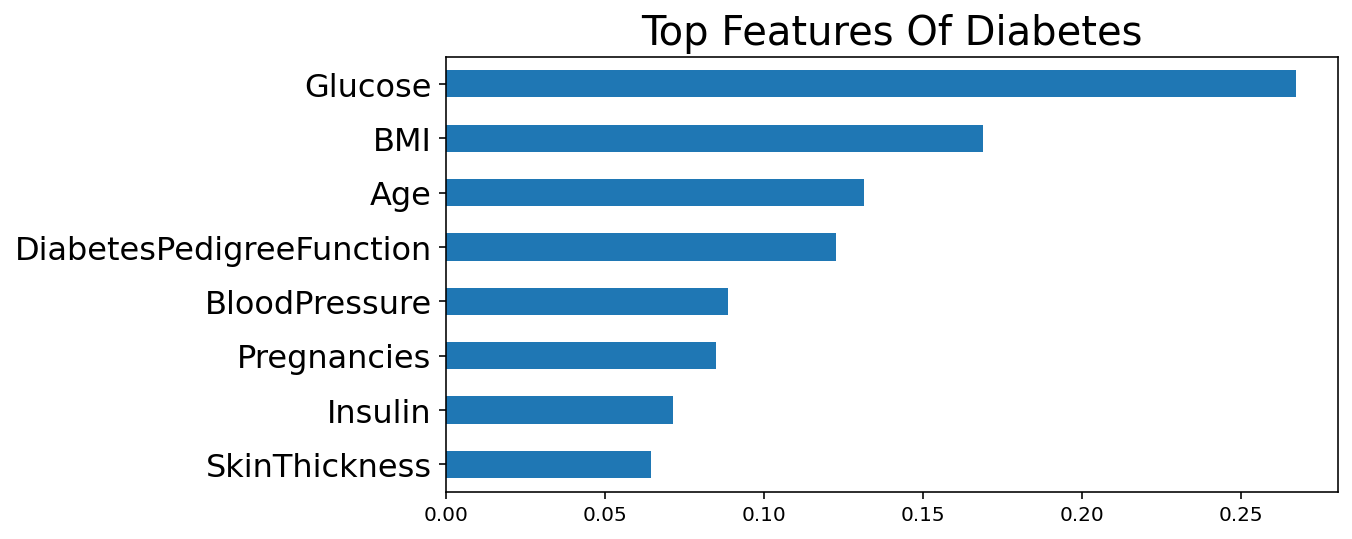

In [519]:
x, y = dataset.drop('Outcome', axis=1).fillna(dataset.drop('Outcome', axis=1).mean()), dataset['Outcome']
rfc = RandomForestClassifier(random_state=SEED, n_estimators=100)
rfc_model = rfc.fit(x, y)
(pd.Series(rfc_model.feature_importances_, index=x.columns)
    .nlargest(8)
    .plot(kind='barh', figsize=[8,4])
    .invert_yaxis())
plt.yticks(size=16)
plt.title('Top Features Of Diabetes', size=20)